# Восстановление золота из руды

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/Gold_bullion_1.jpg/640px-Gold_bullion_1.jpg 'Szaaman')

Здача данного проекта — подготовить прототип модели машинного обучения для компании «Цифра». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


## Подготовка данных

Познакомимся с имеющимися данными.

In [295]:
! gdown 1IIbgWi-ZM1XFuO-GhIHZ1dthaSLuak9Y

Downloading...
From: https://drive.google.com/uc?id=1IIbgWi-ZM1XFuO-GhIHZ1dthaSLuak9Y
To: /content/gold_recovery_train_new.csv
100% 22.8M/22.8M [00:00<00:00, 199MB/s]


In [296]:
! gdown 1E8UvZMO3iCRM7DFWsTAVjLHThqEkdwlZ

Downloading...
From: https://drive.google.com/uc?id=1E8UvZMO3iCRM7DFWsTAVjLHThqEkdwlZ
To: /content/gold_recovery_test_new.csv
100% 5.27M/5.27M [00:00<00:00, 213MB/s]


In [297]:
! gdown 10ElNcgqd2ZnG8utv7peI60rWeMiqU-pR

Downloading...
From: https://drive.google.com/uc?id=10ElNcgqd2ZnG8utv7peI60rWeMiqU-pR
To: /content/gold_recovery_full_new.csv
100% 31.3M/31.3M [00:00<00:00, 209MB/s]


In [298]:
! pip install catboost --quiet

In [299]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

import catboost as cb

In [300]:
sns.set(rc={"figure.figsize":(15, 15)})
sns.set_style("darkgrid")

In [301]:
train = pd.read_csv('/content/gold_recovery_train_new.csv')
test = pd.read_csv('/content/gold_recovery_test_new.csv')
full = pd.read_csv('/content/gold_recovery_full_new.csv')

In [302]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [303]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [304]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Итак, нам доступны три файла с данными: обучающая выборка (`train`), текстовая выборка (`test`) и исходные данные (`full`). В обучающей выборке доступны 14149 записей с 87 колонками, в тестовой — 5290 записей с 53 колонками, в исходной — 19439 записей с 87 колонками. 

В тестовой выборке часть колонок исходной и учебной выборки отсутствует, так как эти параметры замеряются и/или рассчитываются значительно позже предполагаемого времени использования модели.

Видно, что все три набора данных содержат пропуски. Также видно, что для более удобной работы можно изменить тип данных колонки `date` на более подходящий.

### Описание данных
#### Технологический процесс

* *Rougher feed* — исходное сырье
* *Rougher additions* (или *reagent additions*) — флотационные реагенты: *Xanthate, Sulphate, Depressant*
  * *Xanthate* — ксантогенат (промотер, или активатор флотации);
  * *Sulphate* — сульфат (на данном производстве сульфид натрия);
  * *Depressant* — депрессант (силикат натрия).
* *Rougher process* (англ. «грубый процесс») — флотация
* *Rougher tails* — отвальные хвосты
* *Float banks* — флотационная установка
* *Cleaner process* — очистка
* *Rougher Au* — черновой концентрат золота
* *Final Au* — финальный концентрат золота

#### Параметры этапов

* *air amount* — объём воздуха
* *fluid levels* — уровень жидкости
* *feed size* — размер гранул сырья
* *feed rate* — скорость подачи

#### Наименование признаков

Наименование признаков сформировано следующим образом:

`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока `[этап]`:

* *rougher* — флотация
* *primary_cleaner* — первичная очистка
* *secondary_cleaner* — вторичная очистка
* *final* — финальные характеристики

Возможные значения для блока `[тип_параметра]`:

* *input* — параметры сырья
* *output* — параметры продукта
* *state* — параметры, характеризующие текущее состояние этапа
* *calculation* — расчётные характеристики

### Проверка расчёта эффективности обогащения

Проверим правильность расчёта в обучающей выборке эффективности обогащения золота после флотации (признак `rougher.output.recovery`). 

Эффективность обогащения считается по следующей формуле:

$$ Recovery = \frac{C \cdot (F - T) }{F \cdot (C - T)} \cdot 100 \%, $$

где $C$ — доля золота в концентрате после флотации/очистки (в данных находится в колонке `rougher.output.concentrate_au`); $F$ — доля золота в сырье до флотации (в данных находится в колонке `rougher.input.feed_au`); $T$ — доля золота в отвальных хвостах после флотации (в данных находится в колонке `rougher.output.tail_au`).

In [305]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

In [306]:
recovery = 100 * (c * (f - t)) / (f * (c - t))

Найдём среднюю абсолютную ошибку *(MAE)* между нашим расчётом и значением признака.

In [307]:
mae = mean_absolute_error(recovery, train['rougher.output.recovery'])

In [308]:
print(f'Mean absolute error: {mae:.15f}')

Mean absolute error: 0.000000000000011


Видно, что полученная ошибка ничтожно мала и скорее всего связана с точностью расчётов для чисел с плавающей запятой. Значения признака в таблице рассчитаны верно.

### Анализ признаков, недоступных в тестовой выборке

Посмотрим, какие же признаки не попали в тестовую выборку.

In [309]:
train.columns.difference(test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Итак, в тестовую выборку не попали сдедующие признаки

- `final.output.concentrate_ag`
- `final.output.concentrate_au`
- `final.output.concentrate_pb`
- `final.output.concentrate_sol`
- `final.output.recovery`
- `final.output.tail_ag`
- `final.output.tail_au`
- `final.output.tail_pb`
- `final.output.tail_sol`
- `primary_cleaner.output.concentrate_ag`
- `primary_cleaner.output.concentrate_au`
- `primary_cleaner.output.concentrate_pb`
- `primary_cleaner.output.concentrate_sol`
- `primary_cleaner.output.tail_ag`
- `primary_cleaner.output.tail_au`
- `primary_cleaner.output.tail_pb`
- `primary_cleaner.output.tail_sol`
- `rougher.calculation.au_pb_ratio`
- `rougher.calculation.floatbank10_sulfate_to_au_feed`
- `rougher.calculation.floatbank11_sulfate_to_au_feed`
- `rougher.calculation.sulfate_to_au_concentrate`
- `rougher.output.concentrate_ag`
- `rougher.output.concentrate_au`
- `rougher.output.concentrate_pb`
- `rougher.output.concentrate_sol`
- `rougher.output.recovery`
- `rougher.output.tail_ag`
- `rougher.output.tail_au`
- `rougher.output.tail_pb`
- `rougher.output.tail_sol`
- `secondary_cleaner.output.tail_ag`
- `secondary_cleaner.output.tail_au`
- `secondary_cleaner.output.tail_pb`
- `secondary_cleaner.output.tail_sol`

Видно, что в тестовую выборку не попали параметры продукта и расчётные характеристики со всех этапов технологического процесса. При постановке задачи сообщалось, что эти признаки будут недоступны на этапе применения модели.

### Предобработка данных

Проведём предварительную обработку данных. Заполним пропуски, поправим форматы переменных, поищем явные дупликаты. Для удобства дальнейшей работы немного переименуем колонки.

#### Обучающая выборка

Изменим названия колонок, чтобы облегчить дальнейшую работу.

In [310]:
train.columns = train.columns.str.replace('.', '_', regex=False)

In [311]:
# контроль
train.head().T

,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final_output_concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final_output_concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final_output_concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final_output_concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner_state_floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner_state_floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner_state_floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner_state_floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


In [312]:
train.isna().sum().sort_values(ascending=False).head()

secondary_cleaner_output_tail_sol           1605
rougher_state_floatbank10_e_air              436
rougher_input_floatbank11_xanthate           428
primary_cleaner_output_concentrate_sol       286
secondary_cleaner_state_floatbank2_a_air     217
dtype: int64

In [313]:
train['rougher_output_recovery'].isna().sum()

0

In [314]:
train['final_output_recovery'].isna().sum()

0

Видно, что многие колонки содержат пропуски и пропусков довольно много (в колонке `secondary_cleaner_output_tail_sol` их более 1600). Из условий задачи известно, что данные индексируются по времени и соседние по времени параметры часто похожи. Исходя из этой информации заполним пропуски значниями из предыдущих ячеек.

In [315]:
train = train.fillna(method='backfill')

In [316]:
# контроль
train.isna().sum().sum()

0

Изменим тип данных в колонке `date`.

In [317]:
train['date'].head()

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object

In [318]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d %H:%M:%S")

In [319]:
train.dtypes.head()

date                            datetime64[ns]
final_output_concentrate_ag            float64
final_output_concentrate_pb            float64
final_output_concentrate_sol           float64
final_output_concentrate_au            float64
dtype: object

Проверим на наличие явных дупликатов.

In [320]:
train.duplicated().sum()

0

#### Тестовая выборка
Повторим аналогичные действия для тестовой выборки.

In [321]:
test.columns = test.columns.str.replace('.', '_', regex=False)
test = test.fillna(method='backfill')
test['date'] = pd.to_datetime(test['date'], format="%Y-%m-%d %H:%M:%S")
print(f'Количество явных дупликатов: {test.duplicated().sum()}')

Количество явных дупликатов: 0


In [322]:
test.dtypes.head()

date                                datetime64[ns]
primary_cleaner_input_sulfate              float64
primary_cleaner_input_depressant           float64
primary_cleaner_input_feed_size            float64
primary_cleaner_input_xanthate             float64
dtype: object

#### Исходные данные
Наконец, проведём обработку исходных данных.

In [323]:
full.columns = full.columns.str.replace('.', '_', regex=False)
full = full.fillna(method='backfill')
full['date'] = pd.to_datetime(full['date'], format="%Y-%m-%d %H:%M:%S")
print(f'Количество явных дупликатов: {full.duplicated().sum()}')

Количество явных дупликатов: 0


In [324]:
full.dtypes.head()

date                            datetime64[ns]
final_output_concentrate_ag            float64
final_output_concentrate_pb            float64
final_output_concentrate_sol           float64
final_output_concentrate_au            float64
dtype: object

### Промежуточные выводы
Были получены и обработаны три файла с данными. Во всех трёх файлах был обнаружен и исправлен ряд проблем: пропуски данных, нестандарнтное наименование колонок, неоптимальный тип данных в колонке `date`.

Проверка расчёта эффективности обогащения золота после флотации показала, что приведённые в таблице `train` значения корректны.

Было также показано, что в таблицу `test` не попали параметры продукта и расчётные характеристики со всех этапов технологического процесса. При постановке задачи сообщалось, что эти признаки будут недоступны на этапе применения модели.

## Анализ данных

### Изменение концентраций
Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [325]:
def show_conc(name, name_for_plots):
  cols = ['rougher_input_feed_' + name,
          'rougher_output_concentrate_' + name,
          'primary_cleaner_output_concentrate_' + name, 
          'final_output_concentrate_' + name]
  f, [axs_kde, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 15), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[1,1]))
  sns.kdeplot(data=full, x='rougher_input_feed_' + name, 
              shade=True, ax=axs_kde)
  sns.kdeplot(data=full, x='rougher_output_concentrate_' + name, 
              shade=True, ax=axs_kde)
  sns.kdeplot(data=full, x='primary_cleaner_output_concentrate_' + name, 
              shade=True, ax=axs_kde)
  ax = sns.kdeplot(data=full, x='final_output_concentrate_' + name, 
                   shade=True, ax=axs_kde)
  ax.set(title=f'Изменение концентрации {name_for_plots} на различных этапах очистки',
       ylabel=f'Частота значений')
  ax.legend(labels=['до флотации', 
                     'после флотации', 
                     'после первичной очистки',
                     'после вторичной очистки'])
  ax_bp = sns.boxplot(data=full[cols], ax=axs_box, orient='h')
  ax_bp.set(xlabel=f'Концентрация {name_for_plots}')
  ax_bp.set_yticklabels([])

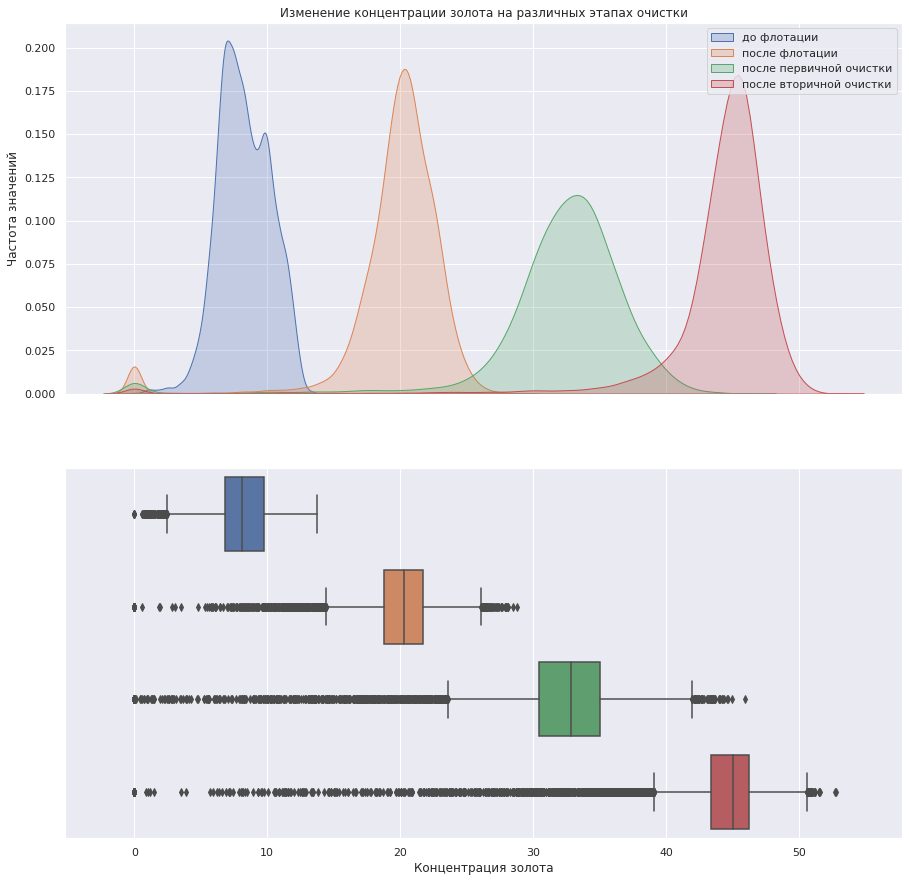

In [326]:
show_conc('au', 'золота')

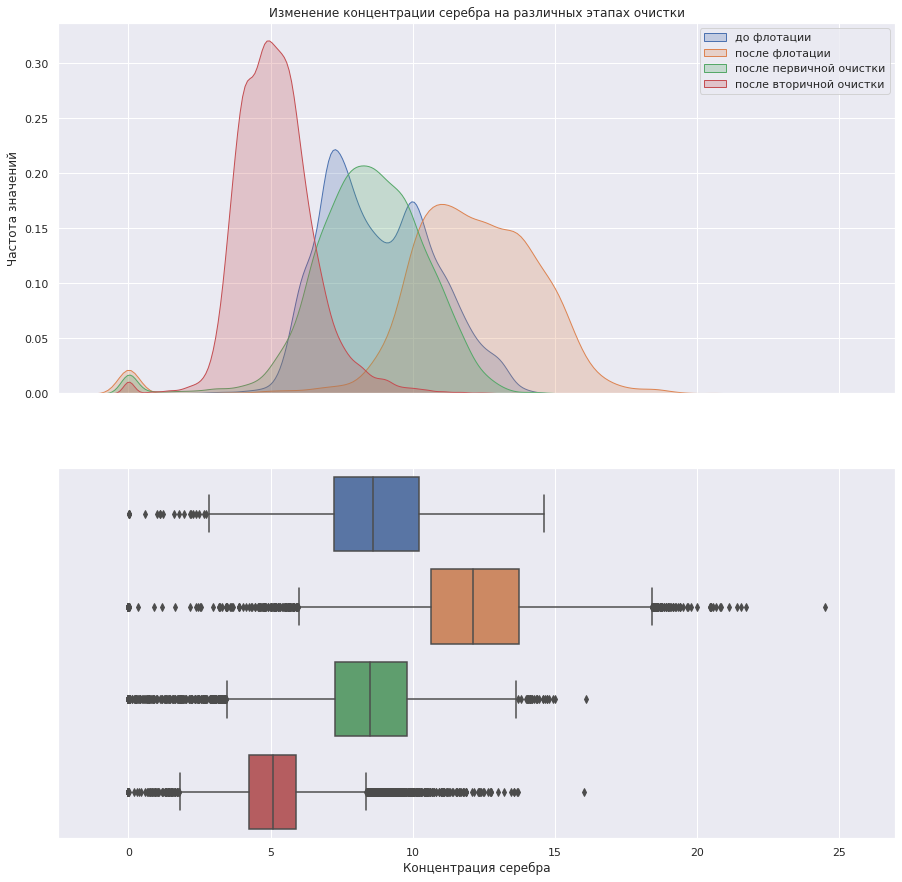

In [327]:
show_conc('ag', 'серебра')

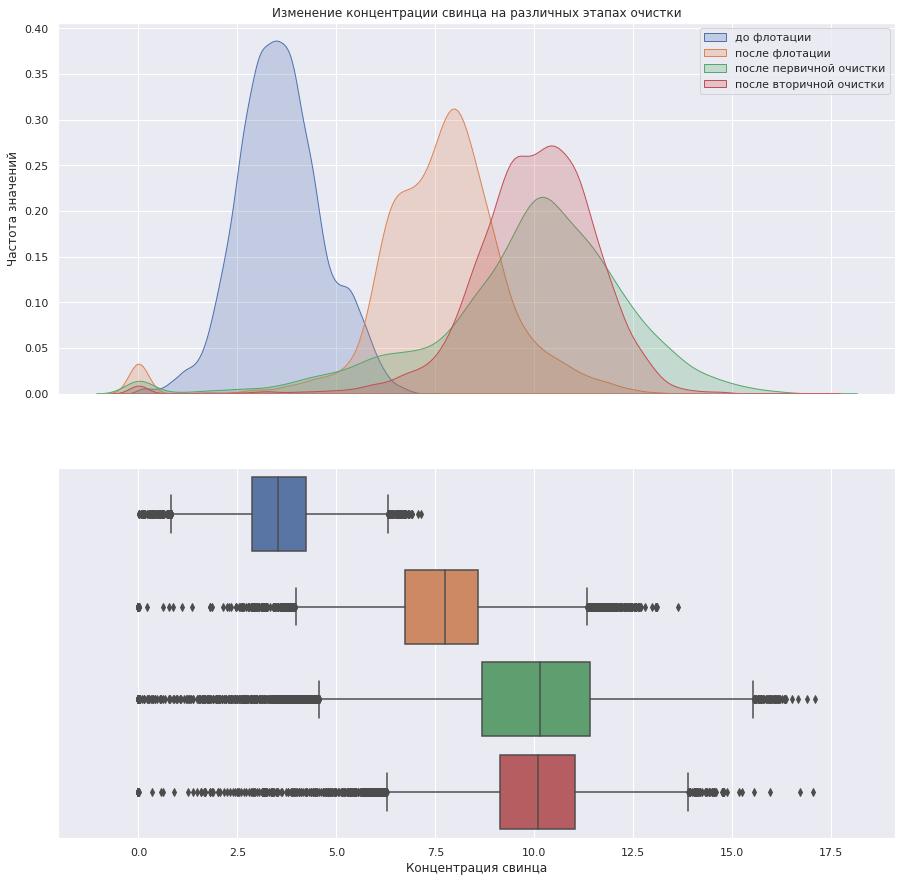

In [328]:
show_conc('pb', 'свинца')

**Вывод** 

Из построенных графиков видно:


*   концентрация золота на каждом последующем этапе обработки увеличивается
*   концентрация серебра увеличивается после флотации, но уменьшается после первичной и вторичной очистки
*   концентрация свинца увеличивается вплоть до вторичной очистки, вторичная очистка практически не влияет на концентрацию свинца.



### Сравнение распределения размеров гранул

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

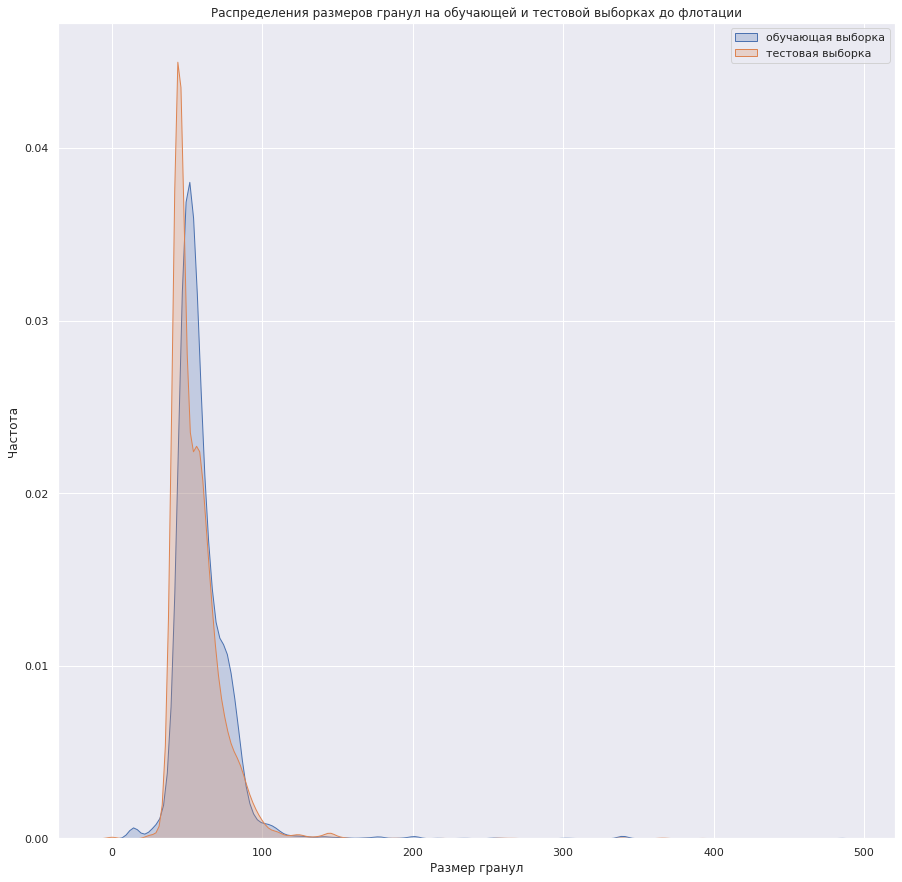

In [329]:
sns.kdeplot(data=train, 
            x='rougher_input_feed_size',
            shade=True)
sns.kdeplot(data=test, 
            x='rougher_input_feed_size',
            shade=True)\
            .set(title='Распределения размеров гранул на обучающей и тестовой выборках до флотации',
                xlabel='Размер гранул',
                ylabel='Частота')
plt.legend(labels=["обучающая выборка","тестовая выборка"])
plt.show()

In [330]:
train['rougher_input_feed_size'].describe()

count    14149.000000
mean        59.955950
std         23.286534
min          9.659576
25%         48.920770
50%         55.301596
75%         65.941463
max        484.967466
Name: rougher_input_feed_size, dtype: float64

In [331]:
test['rougher_input_feed_size'].describe()

count    5290.000000
mean       55.952917
std        19.080412
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher_input_feed_size, dtype: float64

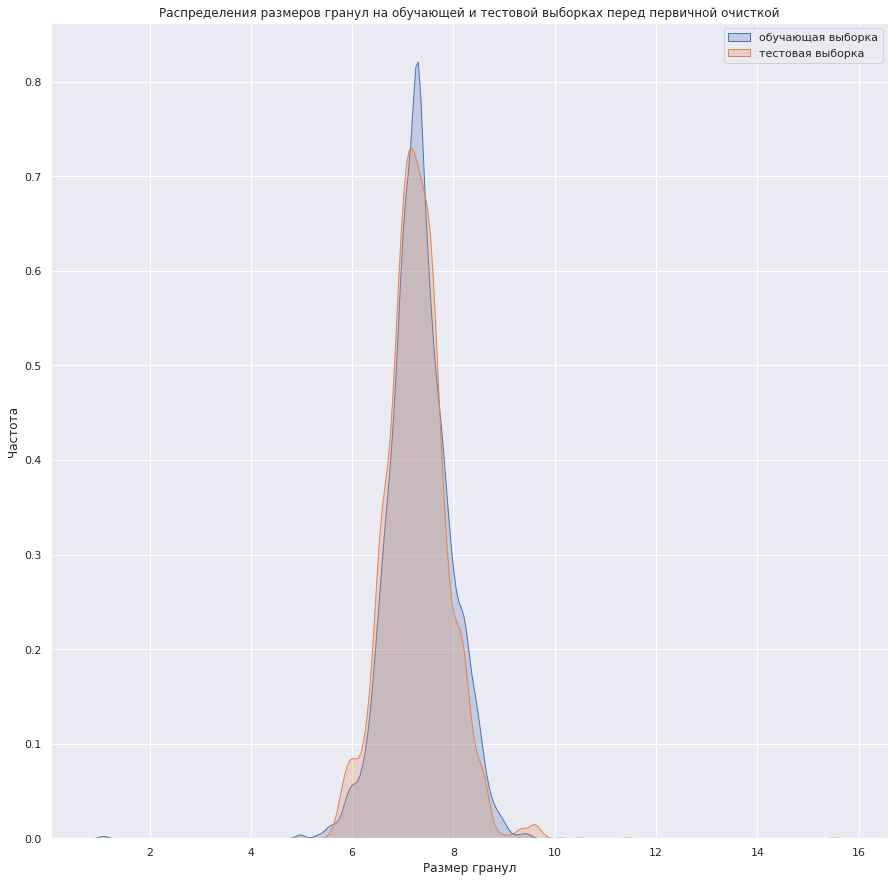

In [332]:
sns.kdeplot(data=train, 
            x='primary_cleaner_input_feed_size',
            shade=True)
sns.kdeplot(data=test, 
            x='primary_cleaner_input_feed_size',
            shade=True)\
            .set(title='Распределения размеров гранул на обучающей и тестовой выборках перед первичной очисткой',
                xlabel='Размер гранул',
                ylabel='Частота')
plt.legend(labels=["обучающая выборка","тестовая выборка"])
plt.show()

In [333]:
train['primary_cleaner_input_feed_size'].describe()

count    14149.000000
mean         7.322310
std          0.614062
min          1.080000
25%          6.960000
50%          7.290000
75%          7.700000
max         10.470000
Name: primary_cleaner_input_feed_size, dtype: float64

In [334]:
test['primary_cleaner_input_feed_size'].describe()

count    5290.000000
mean        7.266339
std         0.610219
min         5.650000
25%         6.890000
50%         7.250000
75%         7.600000
max        15.500000
Name: primary_cleaner_input_feed_size, dtype: float64

Из построенных графиков, значений средних и стандартных отклонений видно, что распределения размеров гранул в обучающей и тестовой выборках схожи между собой. На всякий случай применим тест Левена, чтобы убедиться, что гипотеза о схожести распределений верна.

In [335]:
alpha = 0.05
_, p = st.levene(train['rougher_input_feed_size'], 
                 test['rougher_input_feed_size'])

In [336]:
if p < alpha:
  print('Гипотезу H_0 можно отбросить')
else:
  print('Гипотезу H_0 отбросить нельзя')

Гипотезу H_0 отбросить нельзя


In [337]:
_, p2 = st.levene(train['primary_cleaner_input_feed_size'], 
                  test['primary_cleaner_input_feed_size'])

In [338]:
if p2 < alpha:
  print('Гипотезу H_0 можно отбросить')
else:
  print('Гипотезу H_0 отбросить нельзя')

Гипотезу H_0 отбросить нельзя


Результаты теста Левена не позволяют нам отказаться от гипотезы $H_0$, утверждающей, что между распределениями значений в обучающей и тестовой выборке нет существенных различий.

**Вывод**

Мы проверили гипотезу о том, что между распределениями размеров гранул в обучающей и тестовой выборке нет существенных различий. Помимо визуального сравнения распределений был применён тест Левина. Было установлено, что гипотезу об отсутствии существенных различий нельзя отклонить.

### Изучение суммарной концентрации всех веществ на разных стадиях

Посмотрим, как менялась суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [339]:
joint_conc = pd.DataFrame()
joint_conc['raw'] = train['rougher_input_feed_ag'] +\
train['rougher_input_feed_au'] + train['rougher_input_feed_pb']

In [340]:
joint_conc['crude'] = train['rougher_output_concentrate_ag'] +\
train['rougher_output_concentrate_au'] +\
train['rougher_output_concentrate_pb']

In [341]:
joint_conc['crude2'] = train['primary_cleaner_output_concentrate_ag'] +\
train['primary_cleaner_output_concentrate_au'] +\
train['primary_cleaner_output_concentrate_pb']

In [342]:
joint_conc['fin'] = train['final_output_concentrate_ag'] +\
train['final_output_concentrate_au'] + train['final_output_concentrate_pb']

In [343]:
joint_conc.describe()

,raw,crude,crude2,fin
count,14149.000000,14149.000000,14149.000000,14149.000000
mean,19.952273,38.880325,50.156209,59.278547
std,4.429485,6.927062,7.958401,5.707750
min,0.030000,0.000000,0.000000,0.000000
25%,16.850944,37.925621,49.632637,59.201505
50%,19.179708,39.860389,51.792887,60.260341
75%,22.571605,41.796805,53.440392,61.054829
max,32.840164,55.568687,60.269003,64.968881


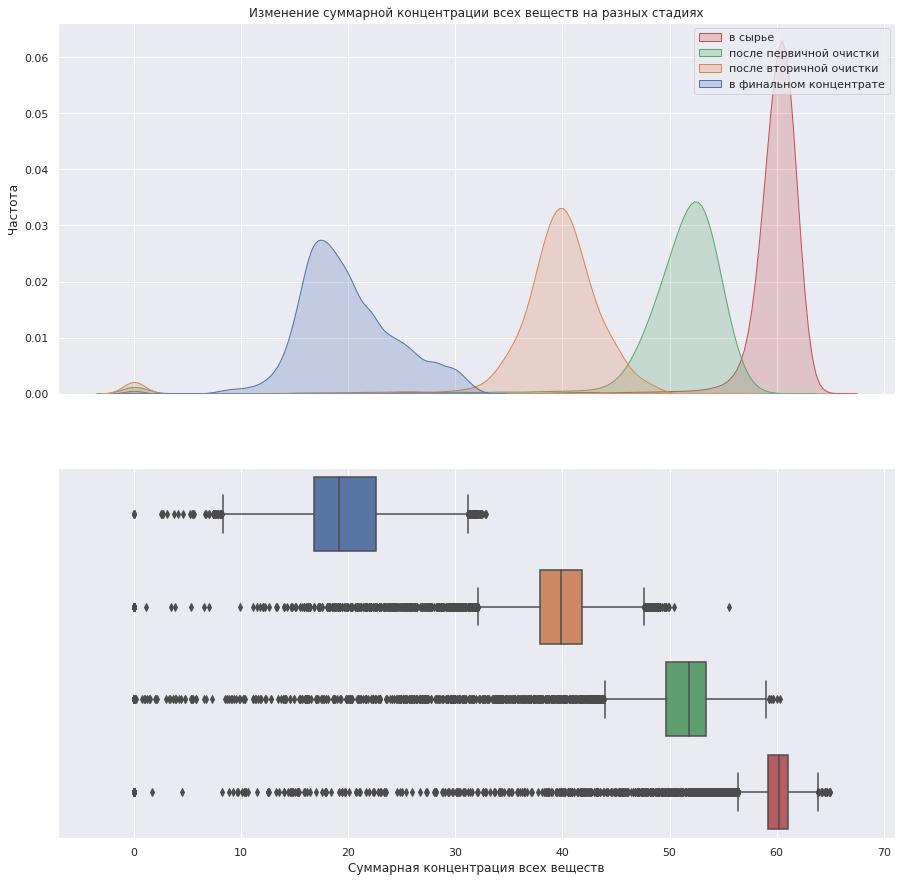

In [344]:
f, [axs_kde, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 15), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[1,1]))
kde = sns.kdeplot(data=joint_conc, shade=True, ax=axs_kde)
kde.set(title='Изменение суммарной концентрации всех веществ на разных стадиях',
     ylabel='Частота')
kde.legend(labels=['в сырье', 'после первичной очистки', 
                   'после вторичной очистки', 'в финальном концентрате'])
box = sns.boxplot(data=joint_conc, orient='h', ax=axs_box)
box.set(xlabel='Суммарная концентрация всех веществ')
box.set_yticklabels([]);

**Вывод**

Из построенного графика видно, что суммарная концентрация всех веществ на протяжении всего технологического процесса понижается. 

При этом видно, что в некоторых случаях суммарная концентрация всех веществ равна нулю. Скорее всего это связано с ошибками в данных, но возможно объясняется какими-то особенностями технологического процесса. Так как в дальнейшем данные из этих колонок не будут использоваться при моделировании (они отсутствуют в тестовой выборке), оставим их без изменений.

### Промежуточные выводы

Нами было проведено несколько исследований, в ходе которых установлено, что


*   концентрация золота на каждом последующем этапе обработки увеличивается
*   концентрация серебра увеличивается после флотации, но уменьшается после первичной и вторичной очистки
*   концентрация свинца увеличивается вплоть до вторичной очистки, вторичная очистка практически не влияет на концентрацию свинца
*   распределения размеров гранул сырья в обучающей и тестовой выборках не имеют существенных отличий
*   суммарная концентрация всех веществ на протяжении всего технологического процесса понижается.

Проверив исходные данные перейдём к моделированию.

## Модель

По условиям задачи необходимо создать модели, прогнозирующие сразу две величины:

*   эффективность обогащения чернового концентрата `rougher.output.recovery`
*   эффективность обогащения финального концентрата `final.output.recovery`

В тестовой выборке целевые параметры отсутствуют, заполним их из полной выборки.

In [345]:
test = pd.merge(test, full[['date', 'rougher_output_recovery', 
                            'final_output_recovery']], how='inner', on='date')

In [346]:
# контроль
test.columns

Index(['date', 'primary_cleaner_input_sulfate',
       'primary_cleaner_input_depressant', 'primary_cleaner_input_feed_size',
       'primary_cleaner_input_xanthate',
       'primary_cleaner_state_floatbank8_a_air',
       'primary_cleaner_state_floatbank8_a_level',
       'primary_cleaner_state_floatbank8_b_air',
       'primary_cleaner_state_floatbank8_b_level',
       'primary_cleaner_state_floatbank8_c_air',
       'primary_cleaner_state_floatbank8_c_level',
       'primary_cleaner_state_floatbank8_d_air',
       'primary_cleaner_state_floatbank8_d_level', 'rougher_input_feed_ag',
       'rougher_input_feed_pb', 'rougher_input_feed_rate',
       'rougher_input_feed_size', 'rougher_input_feed_sol',
       'rougher_input_feed_au', 'rougher_input_floatbank10_sulfate',
       'rougher_input_floatbank10_xanthate',
       'rougher_input_floatbank11_sulfate',
       'rougher_input_floatbank11_xanthate', 'rougher_state_floatbank10_a_air',
       'rougher_state_floatbank10_a_level', 'roughe

Посмотрим на распределения целевых значений в обучающей и тестовой выборках.

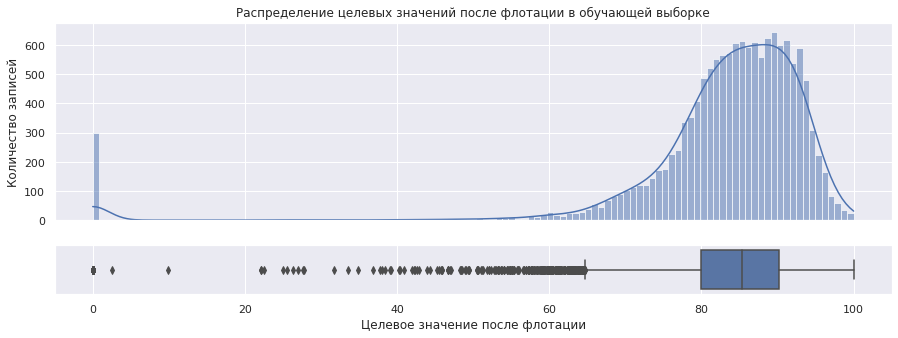

In [347]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[0.8, 0.2]))
sns.histplot(data=train, x='rougher_output_recovery', ax=axs_hist, kde=True)\
.set(title='Распределение целевых значений после флотации в обучающей выборке',
     ylabel='Количество записей')
sns.boxplot(data=train, x='rougher_output_recovery', ax=axs_box)\
.set(xlabel='Целевое значение после флотации');

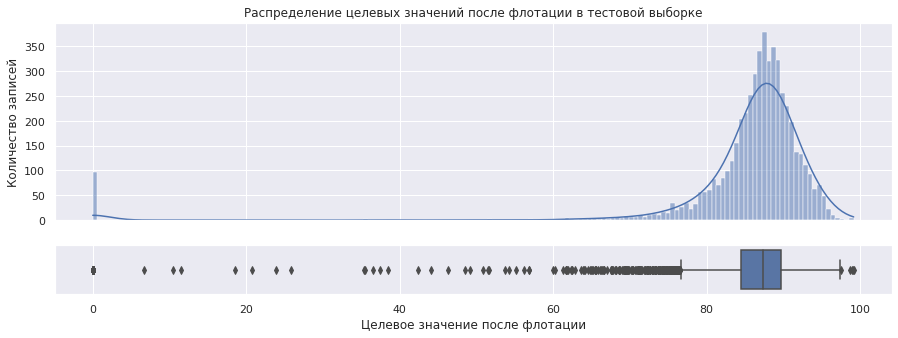

In [348]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[0.8, 0.2]))
sns.histplot(data=test, x='rougher_output_recovery', ax=axs_hist, kde=True)\
.set(title='Распределение целевых значений после флотации в тестовой выборке',
     ylabel='Количество записей')
sns.boxplot(data=test, x='rougher_output_recovery', ax=axs_box)\
.set(xlabel='Целевое значение после флотации');

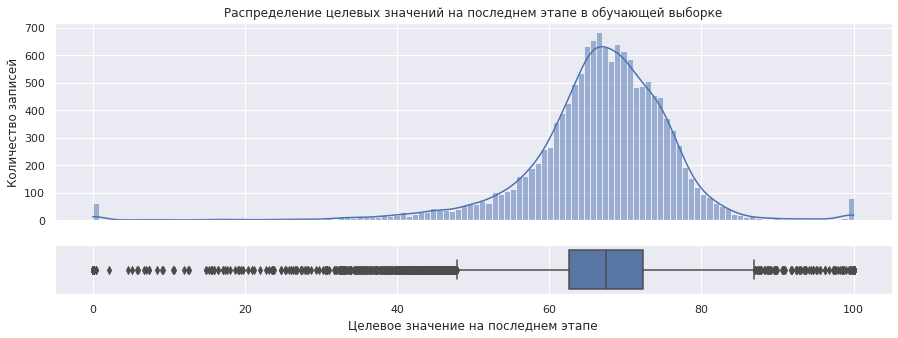

In [349]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[0.8, 0.2]))
sns.histplot(data=train, x='final_output_recovery', ax=axs_hist, kde=True)\
.set(title='Распределение целевых значений на последнем этапе в обучающей выборке',
     ylabel='Количество записей')
sns.boxplot(data=train, x='final_output_recovery', ax=axs_box)\
.set(xlabel='Целевое значение на последнем этапе');

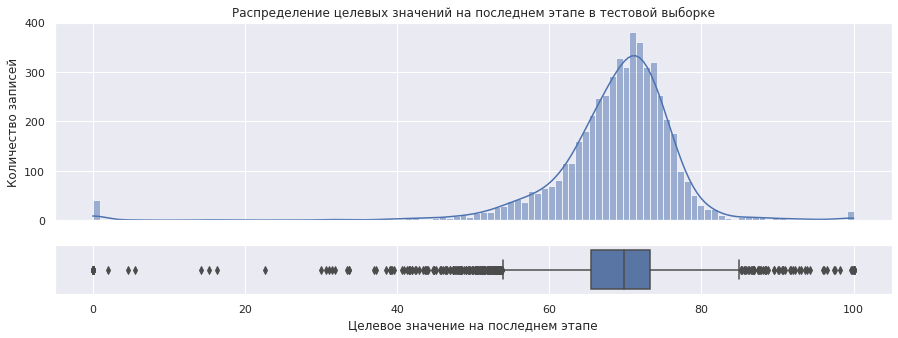

In [350]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[0.8, 0.2]))
sns.histplot(data=test, x='final_output_recovery', ax=axs_hist, kde=True)\
.set(title='Распределение целевых значений на последнем этапе в тестовой выборке',
     ylabel='Количество записей')
sns.boxplot(data=test, x='final_output_recovery', ax=axs_box)\
.set(xlabel='Целевое значение на последнем этапе');

Видно, что во всех четырёх распределениях наблюдаются заметные выбросы нулевых значений. Скорее всего это — ошибки выгрузки данных, удалим их, чтобы модели лучше обучались.

In [351]:
train = train[train['rougher_output_recovery'] != 0]
train = train[train['final_output_recovery'] != 0]

test = test[test['rougher_output_recovery'] != 0]
test = test[test['final_output_recovery'] != 0]

Посмотрим ещё раз на один из графиков, чтобы убедиться, что удаление прошло корректно.

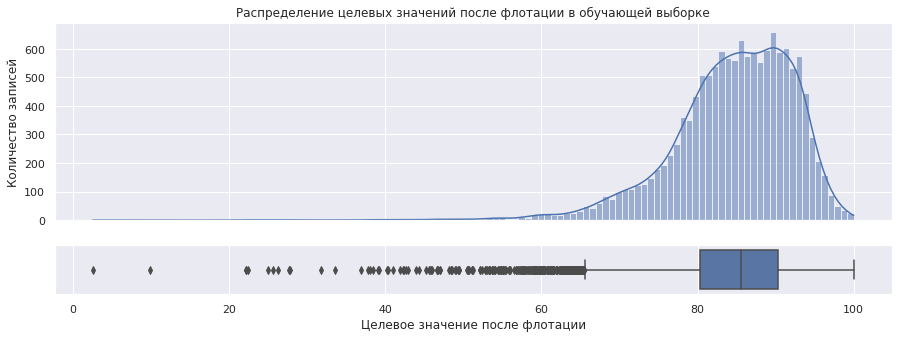

In [352]:
f, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 5), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[0.8, 0.2]))
sns.histplot(data=train, x='rougher_output_recovery', ax=axs_hist, kde=True)\
.set(title='Распределение целевых значений после флотации в обучающей выборке',
     ylabel='Количество записей')
sns.boxplot(data=train, x='rougher_output_recovery', ax=axs_box)\
.set(xlabel='Целевое значение после флотации');

Красота!

### Метрика
Напишем функцию для вычисления метрики sMAPE. Она вычисляется по следующей формуле:

$$sMAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{\left|y_i - \hat{y}_i\right|}
{\left(\left|y_i \right| + \left|\hat{y}_i \right|\right) / 2} \cdot 100\%, $$

где $y_i$ — значение целевого признака для объекта с порядковым номером $i$ в выборке, на которой измеряется качество; $\hat{y}_i$ — значение предсказания для объекта с порядковым номером $i$, например, в тестовой выборке; $N$ — количество объектов в выборке.

In [353]:
def smape(y_true, y_pred):
  # y_true = np.array(y_true)
  # y_pred = np.array(y_pred)
  abs_diff = np.abs(y_true - y_pred)
  half_sum_abs = (np.abs(y_true) + np.abs(y_pred)) / 2
  total_sum = np.sum(abs_diff / half_sum_abs)
  smape = 100 * total_sum / y_true.size
  return smape

При этом итоговая метрика рассчитывается по следующей формуле:

$$sMAPE_t = 25 \% \cdot sMAPE(rougher) + 75 \% \cdot sMAPE(final),$$

где $sMAPE(rougher)$ — значение метрики sMAPE для параметра `rougher.output.recovery`, $sMAPE(final)$ — для параметра `final.output.recovery`.

Напишем соответствующую функцию.

In [354]:
def smape_t(y_true, y_pred):
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  smape_r = smape(y_true[:, 0], y_pred[:, 0])
  smape_f = smape(y_true[:, 1], y_pred[:, 1])
  return .25 * smape_r + .75 * smape_f

In [355]:
smape_scorer = make_scorer(smape_t, greater_is_better=False)

### Создание моделей

Подготовим учебные и тестовые выборки к моделированию.

In [356]:
X_train = train[test.columns].copy()

In [357]:
X_train = X_train.drop(['date', 'rougher_output_recovery', 
                        'final_output_recovery'], axis=1)

In [358]:
y_train = train[['rougher_output_recovery', 'final_output_recovery']].copy()

In [359]:
X_test = test.copy()

In [360]:
X_test = X_test.drop(['date', 'rougher_output_recovery',
                      'final_output_recovery'], axis=1)

In [361]:
y_test = test[['rougher_output_recovery', 'final_output_recovery']].copy()

Создадим несколько моделей и отберём из них ту, что обеспечит наилучшие значения метрики sMAPE на кросс-валидации. Проверим следующие модели:


*   регрессор на основе метода $k$-ближайших соседей
*   регрессор на основе случайного леса
*   регрессор на основе линейной регрессии
*   регрессор на основе модели Lasso.

Перед обучением моделей будем проводить масштабирование данных.


In [362]:
knn_pipeline = Pipeline([("scaler", MinMaxScaler()),
                       ("reg", KNeighborsRegressor())])

rf_pipeline = Pipeline([("scaler", StandardScaler()),
                       ("reg", RandomForestRegressor(random_state=42))])

lr_pipeline = Pipeline([("scaler", StandardScaler()),
                       ("reg", LinearRegression())])

ls_pipeline = Pipeline([("scaler", StandardScaler()),
                       ("reg", MultiTaskLasso())])

In [363]:
knn_params = {'reg__n_neighbors': list(range(3, 7, 1))}

In [364]:
rf_params = {'reg__n_estimators': list(range(90, 120, 10)),
             'reg__min_samples_split': list(range(2, 4, 1))}

In [365]:
ls_params = {'reg__alpha': [.9, 1., 1.1],
             'reg__max_iter': [900, 1000, 1100]}

### Кросс-валидация
Итак, мы готовы к кросс-валидации!

In [366]:
rf_grid = GridSearchCV(estimator=rf_pipeline, 
                        param_grid=rf_params, 
                        scoring=smape_scorer, verbose=2)

In [367]:
%%time
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....reg__min_samples_split=2, reg__n_estimators=90; total time= 1.2min
[CV] END .....reg__min_samples_split=2, reg__n_estimators=90; total time= 1.0min
[CV] END .....reg__min_samples_split=2, reg__n_estimators=90; total time=  54.3s
[CV] END .....reg__min_samples_split=2, reg__n_estimators=90; total time=  55.5s
[CV] END .....reg__min_samples_split=2, reg__n_estimators=90; total time=  56.8s
[CV] END ....reg__min_samples_split=2, reg__n_estimators=100; total time= 1.1min
[CV] END ....reg__min_samples_split=2, reg__n_estimators=100; total time= 1.1min
[CV] END ....reg__min_samples_split=2, reg__n_estimators=100; total time=  59.5s
[CV] END ....reg__min_samples_split=2, reg__n_estimators=100; total time= 1.0min
[CV] END ....reg__min_samples_split=2, reg__n_estimators=100; total time= 1.1min
[CV] END ....reg__min_samples_split=2, reg__n_estimators=110; total time= 1.2min
[CV] END ....reg__min_samples_split=2, reg__n_est

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'reg__min_samples_split': [2, 3],
                         'reg__n_estimators': [90, 100, 110]},
             scoring=make_scorer(smape_t, greater_is_better=False), verbose=2)

In [368]:
scores = pd.DataFrame()

In [369]:
scores['rf'] = cross_val_score(rf_grid.best_estimator_, X_train, 
                               y_train, scoring=smape_scorer)

In [370]:
smape_t(y_test, rf_grid.best_estimator_.predict(X_test))

8.255813880248436

In [371]:
knn_grid = GridSearchCV(estimator=knn_pipeline, 
                        param_grid=knn_params, 
                        scoring=smape_scorer, verbose=2)

In [372]:
%%time
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END .................................reg__n_neighbors=3; total time=   0.6s
[CV] END .................................reg__n_neighbors=3; total time=   0.5s
[CV] END .................................reg__n_neighbors=3; total time=   0.5s
[CV] END .................................reg__n_neighbors=3; total time=   0.5s
[CV] END .................................reg__n_neighbors=3; total time=   0.5s
[CV] END .................................reg__n_neighbors=4; total time=   0.5s
[CV] END .................................reg__n_neighbors=4; total time=   0.5s
[CV] END .................................reg__n_neighbors=4; total time=   0.5s
[CV] END .................................reg__n_neighbors=4; total time=   0.5s
[CV] END .................................reg__n_neighbors=4; total time=   0.5s
[CV] END .................................reg__n_neighbors=5; total time=   0.5s
[CV] END .................................reg__n_

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('reg', KNeighborsRegressor())]),
             param_grid={'reg__n_neighbors': [3, 4, 5, 6]},
             scoring=make_scorer(smape_t, greater_is_better=False), verbose=2)

In [373]:
scores['knn'] = cross_val_score(knn_grid.best_estimator_, X_train, 
                                y_train, scoring=smape_scorer)

In [374]:
smape_t(y_test, knn_grid.best_estimator_.predict(X_test))

7.3986016007022615

In [375]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('reg', LinearRegression())])

In [376]:
scores['lr'] = cross_val_score(lr_pipeline, X_train, 
                               y_train, scoring=smape_scorer)

In [377]:
smape_t(y_test, lr_pipeline.predict(X_test))

7.697982081429092

In [378]:
ls_grid = GridSearchCV(estimator=ls_pipeline, 
                        param_grid=ls_params, 
                        scoring=smape_scorer, verbose=2)

In [379]:
%%time
ls_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..................reg__alpha=0.9, reg__max_iter=900; total time=   0.1s
[CV] END ..................reg__alpha=0.9, reg__max_iter=900; total time=   0.1s
[CV] END ..................reg__alpha=0.9, reg__max_iter=900; total time=   0.0s
[CV] END ..................reg__alpha=0.9, reg__max_iter=900; total time=   0.1s
[CV] END ..................reg__alpha=0.9, reg__max_iter=900; total time=   0.1s
[CV] END .................reg__alpha=0.9, reg__max_iter=1000; total time=   0.1s
[CV] END .................reg__alpha=0.9, reg__max_iter=1000; total time=   0.1s
[CV] END .................reg__alpha=0.9, reg__max_iter=1000; total time=   0.0s
[CV] END .................reg__alpha=0.9, reg__max_iter=1000; total time=   0.1s
[CV] END .................reg__alpha=0.9, reg__max_iter=1000; total time=   0.0s
[CV] END .................reg__alpha=0.9, reg__max_iter=1100; total time=   0.1s
[CV] END .................reg__alpha=0.9, reg__ma

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg', MultiTaskLasso())]),
             param_grid={'reg__alpha': [0.9, 1.0, 1.1],
                         'reg__max_iter': [900, 1000, 1100]},
             scoring=make_scorer(smape_t, greater_is_better=False), verbose=2)

In [380]:
scores['ls'] = cross_val_score(ls_grid.best_estimator_, X_train, 
                               y_train, scoring=smape_scorer)

In [381]:
smape_t(y_test, ls_grid.best_estimator_.predict(X_test))

6.367640296753096

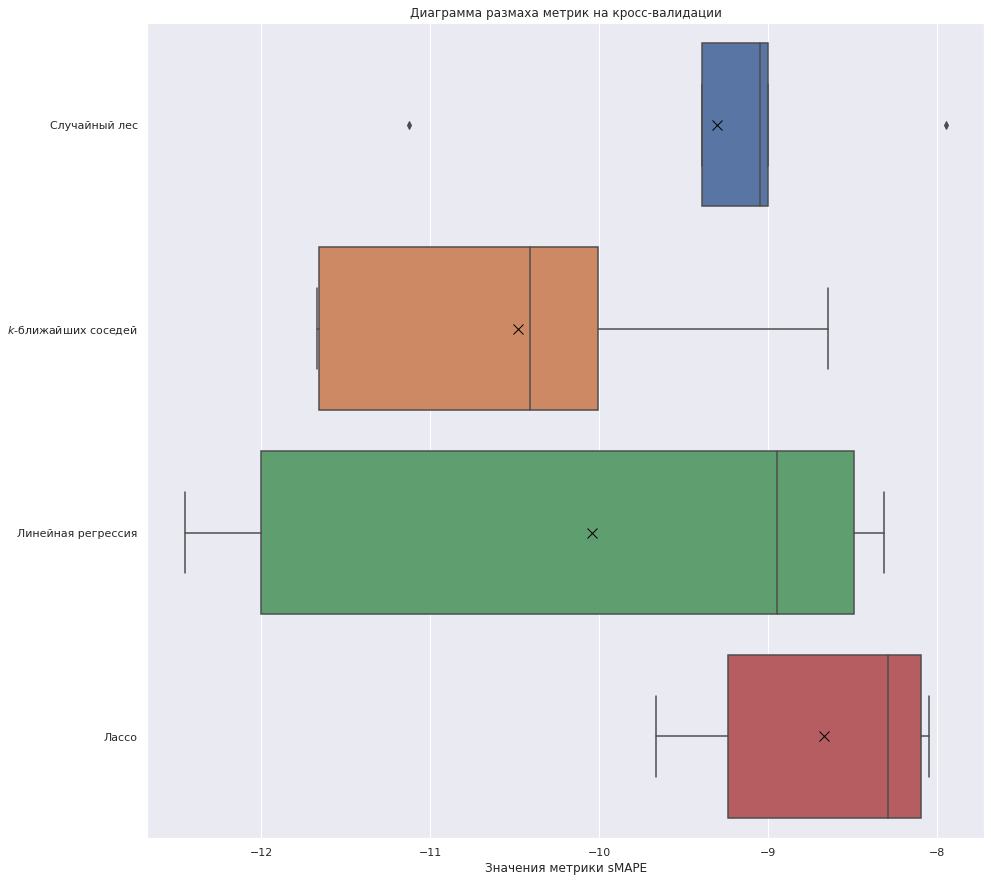

In [382]:
cv_bp = sns.boxplot(data=scores, orient='h', showmeans=True, 
                    meanprops={'marker': 'x',
                               'markeredgecolor': 'black',
                               'markersize': '10'})
cv_bp.set(title='Диаграмма размаха метрик на кросс-валидации',
     xlabel='Значения метрики sMAPE');
cv_bp.set_yticklabels(['Случайный лес', 
                     '$k$-ближайших соседей', 
                     'Линейная регрессия',
                     'Лассо']);

Итак, рассматриваемые нами модели дали следующие значения метрики sMAPE на тестовой выборке:

| Модель | Значение sMAPE |
| ----------- | ----------- |
| Случайный лес | 8.26 |
| $k$-ближайших соседей | 7.40 | 
| Линейная регрессия | 7.70 | 
| Лассо | 6.37 | 

Попробуем применить для решения данной задачи CatBoost.

In [383]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [384]:
model = cb.CatBoostRegressor(loss_function='MultiRMSE', verbose=False)

In [385]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [386]:
model.grid_search(grid, train_dataset, verbose=100)


bestTest = 11.55098508
bestIteration = 99

0:	loss: 11.5509851	best: 11.5509851 (0)	total: 718ms	remaining: 1m 8s

bestTest = 8.946581017
bestIteration = 99


bestTest = 11.55182028
bestIteration = 99


bestTest = 8.947897271
bestIteration = 99


bestTest = 11.55708263
bestIteration = 99


bestTest = 8.937479286
bestIteration = 99


bestTest = 11.57054526
bestIteration = 99


bestTest = 8.955989639
bestIteration = 99


bestTest = 9.748015875
bestIteration = 149


bestTest = 8.709614487
bestIteration = 149


bestTest = 9.749019763
bestIteration = 149


bestTest = 8.709813066
bestIteration = 149


bestTest = 9.747359807
bestIteration = 149


bestTest = 8.700518395
bestIteration = 149


bestTest = 9.759509458
bestIteration = 149


bestTest = 8.68708395
bestIteration = 149


bestTest = 9.374896589
bestIteration = 199


bestTest = 8.513707578
bestIteration = 199


bestTest = 9.376330911
bestIteration = 199


bestTest = 8.518382606
bestIteration = 199


bestTest = 9.371317957
bestIteration 

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [387]:
smape_t(y_test, model.predict(X_test))

7.015797577878082

Дополним нашу таблицу.

| Модель | Значение sMAPE |
| ----------- | ----------- |
| Случайный лес | 8.26 |
| $k$-ближайших соседей | 7.40 | 
| Линейная регрессия | 7.70 | 
| Лассо | 6.37 | 
| CatBoost | 7.02 | 

### Сравнение с «глупой» моделью
Чтобы убедиться, что предсказания наших моделей действительно имеют ценность, сравним их с «глупой» моделью, которая всегда предсказывает среднее значение.

In [388]:
dummy = DummyRegressor(strategy='mean')

In [389]:
dummy.fit(X_train, y_train)

DummyRegressor()

In [390]:
smape_t(y_test, dummy.predict(X_test))

7.766604067388528

Видно, что у «глупой» модели целевая метрика выходит хуже, чем у некоторых из разработанных нами моделей.

### Промежуточные выводы

Были созданы пять моделей, предсказывающих значения целевых признаков. В результате обучения на тестовой выборке наилучшее знацение метрики sMAPE удалось достичь на модели Лассо. Для контроля полученных данных мы сравнили результаты работы моделей с простой моделью, которая всегда предсказывает среднее значение. У такой модели значение целевой метрики оказалось ниже, чем у разработанных нами моделей.

## Общий вывод по проекту

Были получены данные по процессу восстановления золота из руды. В ходе предварительного анализа в данных были выявлены и исправлены незначительные проблемы.

Была проверена правильность расчёта в обучающей выборке эффективности обогащения золота после флотации.

Был проведён анализ полученных данных для выявления общих закономерностей технологического процесса и проверки готовности данных для моделирования. Нами установлено, что

*   концентрация золота на каждом последующем этапе обработки увеличивается
*   концентрация серебра увеличивается после флотации, но уменьшается после первичной и вторичной очистки
*   концентрация свинца увеличивается вплоть до вторичной очистки, вторичная очистка практически не влияет на концентрацию свинца
*   распределения размеров гранул сырья в обучающей и тестовой выборках не имеют существенных отличий
*   суммарная концентрация серебра, свинца и золота на протяжении всего технологического процесса понижается.

Наконец, были обучены пять моделей, предсказывающих значения целевых параметров. Для моделей были подобраны гипер-параметры, обеспечивающие наилучшие значения метрики на кросс-валидации. Затем для каждой модели была расчитана метрика _sMAPE_ на тестовых данных.

| Модель | Значение sMAPE |
| ----------- | ----------- |
| Случайный лес | 8.26 |
| $k$-ближайших соседей | 7.40 | 
| Линейная регрессия | 7.70 | 
| Лассо | 6.37 | 
| CatBoost | 7.02 | 

Наилучшее значение метрики удалось получить для линейной модели Лассо, которую рекомендуется применять на производстве.